In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
data = sm.datasets.macrodata.load_pandas().data
data.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


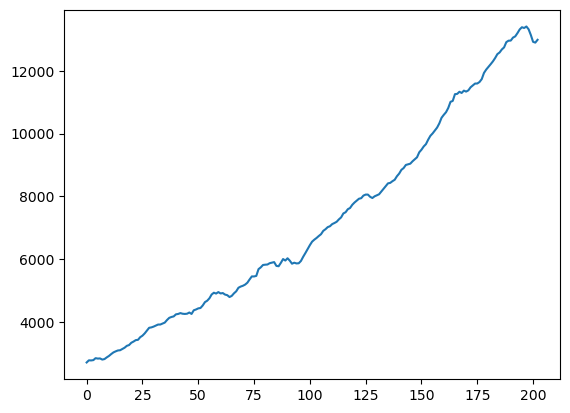

In [3]:
plt.plot(data['realgdp'])

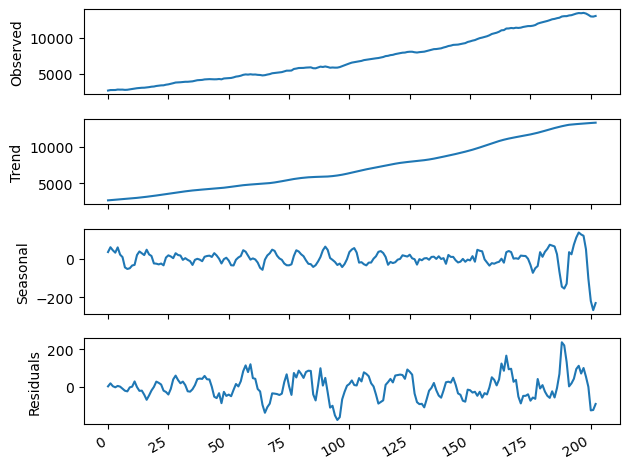

In [4]:
advanced_decomposition=STL(data.realgdp, period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')

fig.autofmt_xdate()
plt.tight_layout()


In [5]:
#check for the stationarity test

adfuller(data['realgdp'])

(1.7504627967647144,
 0.9982455372335032,
 12,
 190,
 {'1%': -3.4652439354133255,
  '5%': -2.8768752281673717,
  '10%': -2.574944653739612},
 2034.517123668382)

It is not stationary

In [6]:
adfuller(np.diff(data['realgdp'],n=1))

(-6.305695561658106,
 3.327882187668224e-08,
 1,
 200,
 {'1%': -3.463476079125, '5%': -2.876102355, '10%': -2.574532225},
 2024.992358126391)

In [7]:
adfuller(np.diff(data['realgdp'],n=4))

(-7.683876738494243,
 1.479205079476572e-11,
 15,
 183,
 {'1%': -3.466598080268425,
  '5%': -2.8774669520682674,
  '10%': -2.5752604356654425},
 2065.3240987626805)

It became sattionary we can say the d=1 and D is 0 or 4 

In [8]:
data.shape

(203, 14)

In [9]:
train=data[:-7]
test=data[:-7]

In [10]:
def optimize_sarimax(df, target, order_list, d, s):
    results = []
    
    for i in order_list:
        try:
            model = SARIMAX(endog=df[target],
                            exog=df[[col for col in df.columns if col != target]],
                            simple_differencing=False,
                            order=(i[0], d, i[1]),
                            seasonal_order=(i[2], 0, i[3], s)).fit(disp=False)
            aic = model.aic
            results.append([d, i, aic])
        except:
            continue
    
    result = pd.DataFrame(results)
    result.columns = ['d', 'order', 'aic']
    result.sort_values(by='aic')
    
    return result

In [11]:
ps=range(0,4,1)
d=1
qs=range(0,4,1)

Ps=range(0,4,1)
Qs=range(0,4,1)
s=4

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)

target='realgdp'

res=optimize_sarimax(train, target, parameters_list, d, s)


In [12]:
res.sort_values(by='aic',inplace=True)

In [17]:
res

,d,order,aic
176,1,"(2, 3, 0, 0)",1720.656737
240,1,"(3, 3, 0, 0)",1722.844446
181,1,"(2, 3, 1, 1)",1724.151026
244,1,"(3, 3, 1, 0)",1724.633500
241,1,"(3, 3, 0, 1)",1724.640102
...,...,...,...
238,1,"(3, 2, 3, 2)",1734.717381
237,1,"(3, 2, 3, 1)",1734.729391
223,1,"(3, 1, 3, 3)",1734.976719
191,1,"(2, 3, 3, 3)",1735.078841


In [20]:
model=SARIMAX(endog=train[target],exog=train[[col for col in train.columns if col != target]],
                                simple_differencing=False,
                                order=(2,1,2), seasonal_order=(1,0,0,4)).fit(disp=False)

In [21]:
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                            realgdp   No. Observations:                  196
Model:             SARIMAX(2, 1, 2)x(1, 0, [], 4)   Log Likelihood                -844.001
Date:                            Sat, 03 Jun 2023   AIC                           1726.001
Time:                                    07:49:48   BIC                           1788.188
Sample:                                         0   HQIC                          1751.180
                                            - 196                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year          32.8742     54.241      0.606      0.544     -73.436     139.184
quarter        8.7160     14.044   

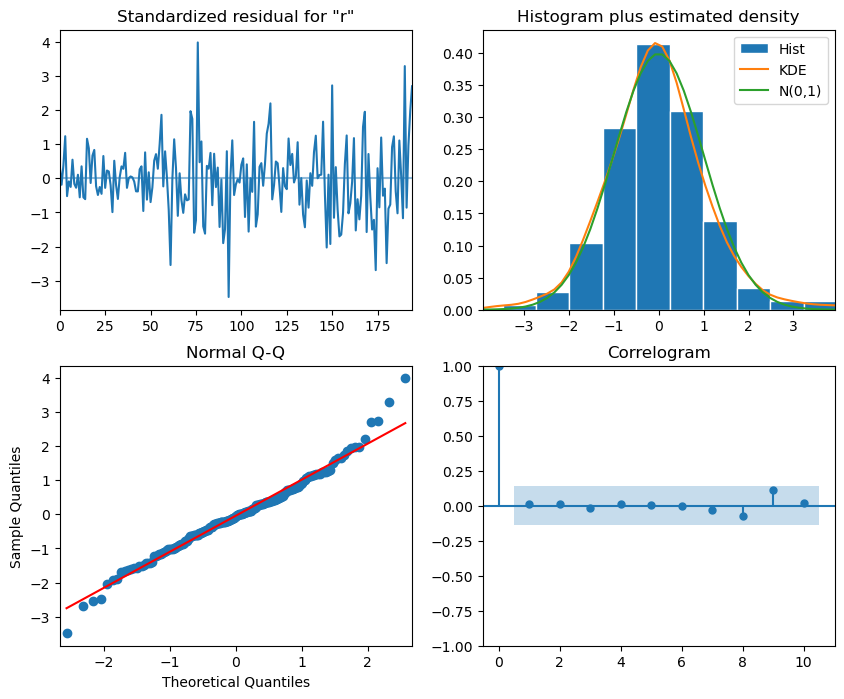

In [22]:
model.plot_diagnostics(figsize=(10,8));

In [23]:
residuals = model.resid

val= acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(val)

     lb_stat  lb_pvalue
1   0.000004   0.998344
2   0.000004   0.999998
3   0.000013   1.000000
4   0.000059   1.000000
5   0.000059   1.000000
6   0.000064   1.000000
7   0.000068   1.000000
8   0.000099   1.000000
9   0.000108   1.000000
10  0.000117   1.000000


In [24]:
def recursive_forecast(endog: Union[pd.Series, list], exog: Union[pd.Series, list], train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon

    if method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = endog[:i].iloc[-1]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'SARIMAX':
        pred_SARIMAX = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(endog[:i], exog[:i], order=(2,1,2), seasonal_order=(1,0,0,4), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(exog=exog)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMAX.extend(oos_pred)
            
        return pred_SARIMAX

In [27]:
target = data['realgdp']
exog = data[['realcons', 'realinv', 'realgovt', 'realdpi', 'cpi', 
                        'm1', 'tbilrate', 'unemp', 'pop', 'infl', 'realint']]

target_train = target[:200]
exog_train = exog[:200]

target_train = target[:196]
target_test = target[196:]

pred_df = pd.DataFrame({'actual': target_test})

TRAIN_LEN = len(target_train)
HORIZON = len(target_test)
WINDOW = 1

pred_last_value = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_SARIMAX = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'SARIMAX')

pred_df['pred_last_value'] = pred_last_value
pred_df['pred_SARIMAX'] = pred_SARIMAX

pred_df

,actual,pred_last_value,pred_SARIMAX
196,13366.865,13391.249,13345.323465
197,13415.266,13366.865,13374.991346
198,13324.600,13415.266,13368.458066
199,13141.920,13324.600,13332.370212
200,12925.410,13141.920,13135.312953
201,12901.504,12925.410,12887.761999
202,12990.341,12901.504,12868.822028


0.736849498653785 0.70080434122877


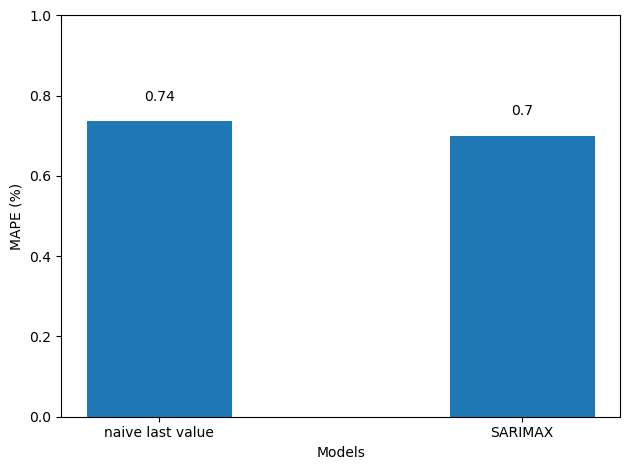

In [29]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_last = mape(pred_df.actual, pred_df.pred_last_value)
mape_SARIMAX = mape(pred_df.actual, pred_df.pred_SARIMAX)

print(mape_last, mape_SARIMAX)

fig, ax = plt.subplots()

x = ['naive last value', 'SARIMAX']
y = [mape_last, mape_SARIMAX]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 1)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()

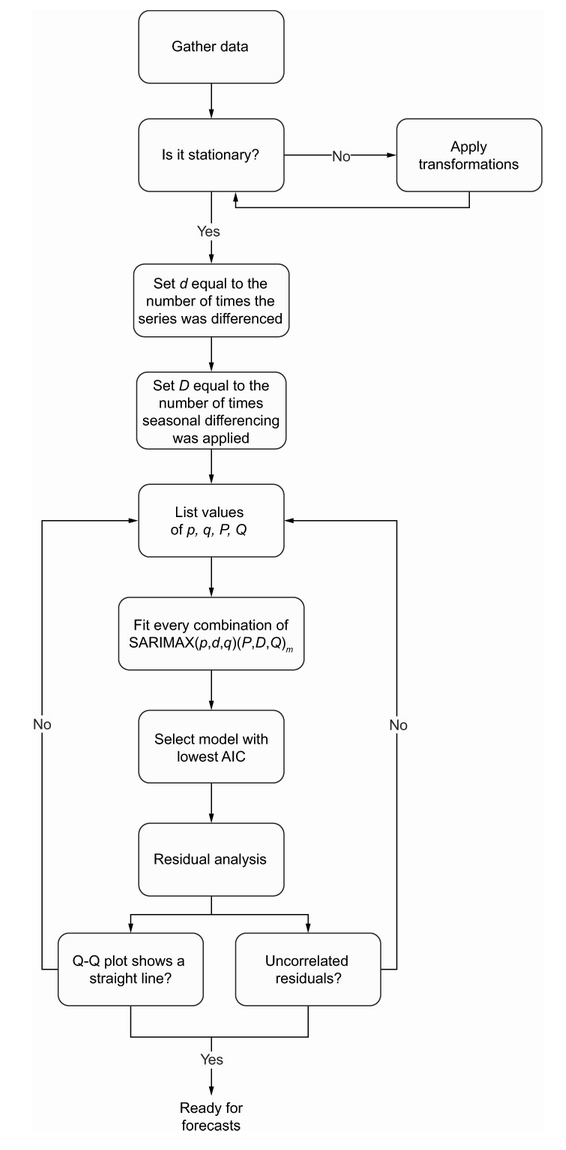

There is an important caveat that comes with the use of the SARIMAX model. Including external variables can potentially be beneficial, as you may find strong predictors for your target. However, you might encounter issues when forecasting multiple timesteps into the future.

Recall that the SARIMAX model uses the SARIMA(p,d,q) (P,D,Q)m model and a linear combination of exogenous variables to predict one timestep into the future. But what if you wish to predict two timesteps into the future? While this is possible with a SARIMA model, the SARIMAX model requires us to forecast the exogenous variables too.

To illustrate this idea, let’s assume that realcons is a predictor of realgdp (this will be verified later in the chapter). Assume also that we have a SARIMAX model where realcons is used as an input feature to predict realgdp. Now suppose that we are at the end of 2009 and must predict the real GDP for 2010 and 2011. The SARIMAX model allows us to use the realcons of 2009 to predict the real GDP for 2010. However, predicting the real GDP for 2011 will require us to predict realcons for 2010, unless we wait to observe the value at the end of 2010.

Because the realcons variable is a time series itself, it can be forecast using a version of the SARIMA model. Nevertheless, we know that our forecast always has some error associated with it. Therefore, having to forecast an exogenous variable to forecast our target variable can magnify the prediction error of our target, meaning that our predictions can quickly degrade as we predict more timesteps into the future.

The only way to avoid that situation is to predict only one timestep into the future and wait to observe the exogenous variable before predicting the target for another timestep into the future.

On the other hand, if your exogenous variable is easy to predict, meaning that it follows a known function that can be accurately predicted, there is no harm in forecasting the exogenous variable and using these forecasts to predict the target.

In the end, there is no clear recommendation to predict only one timestep. It is dependent on the situation and the exogenous variables available. This is where your expertise as a data scientist and rigorous experimenting come into play. If you determine that your exogenous variable can be accurately predicted, you can recommend forecasting many timesteps into the future. Otherwise, your recommendation must be to predict one timestep at a time and justify your decision by explaining that errors will accumulate as more predictions are made, meaning that the forecasts will lose accuracy.

Now that we have explored the SARIMAX model in depth, let’s apply it to forecast the real GDP.